In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision
import torch
import numpy as np
from tqdm.notebook import tqdm

In [3]:
dataset_folder = "/home/jordan/github/datasets/ball_pythons/"

In [4]:
main_folder_list = os.listdir(dataset_folder)
morph_folder_list = [f"{dataset_folder}{i}/" for i in main_folder_list if "%" not in i and "." not in i and "Pos" not in i]

FileNotFoundError: [Errno 2] No such file or directory: '/home/jordan/github/datasets/ball_pythons/'

In [6]:
morph_img_folder_dict = {}
for morph_folder in morph_folder_list:
    morph_img_folder_list = os.listdir(morph_folder)
    morph_img_folder_list = [f"{morph_folder}{i}/" for i in morph_img_folder_list]
    if len(morph_img_folder_list) > 20:
        morph_img_folder_dict[morph_folder.split("/")[-2]] = {"img_folders": morph_img_folder_list,
        "num_imgs": len(morph_img_folder_list)}

/tmp/ipykernel_20036/3596800513.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


total imgs in dict: 11719 - 28 morphs


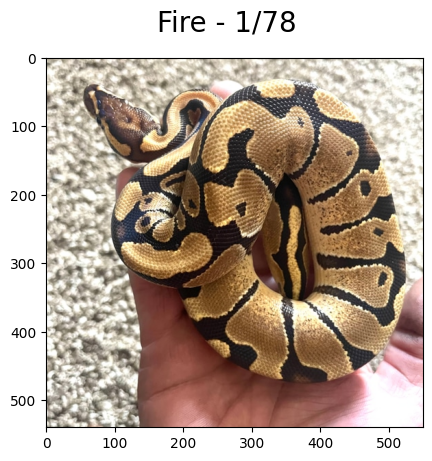

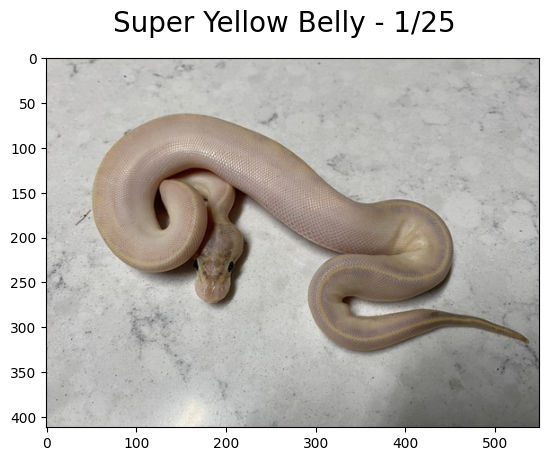

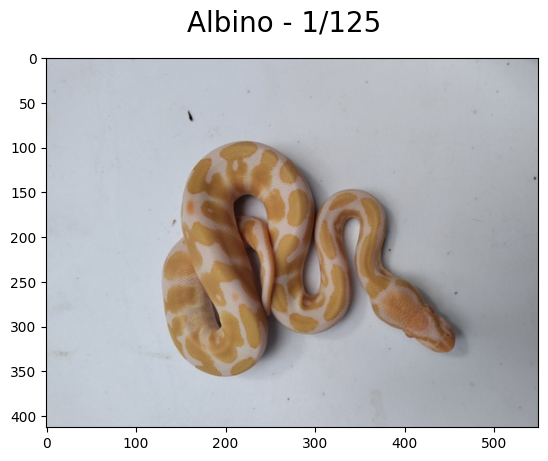

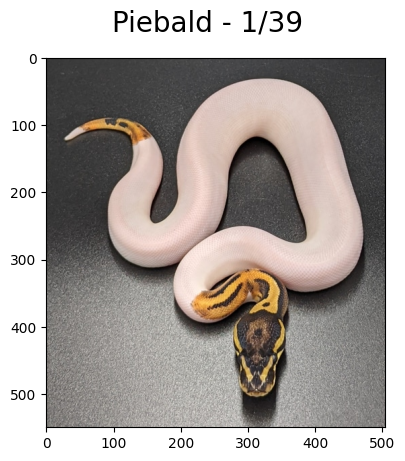

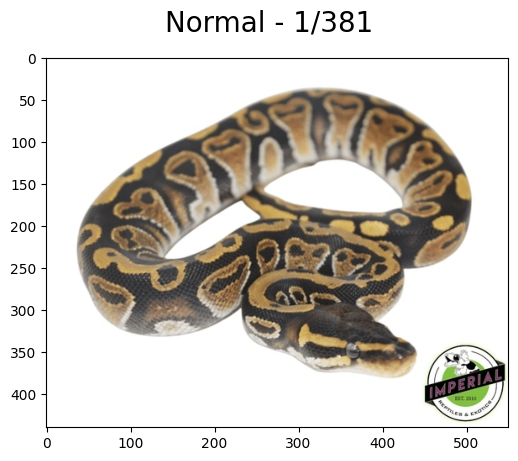

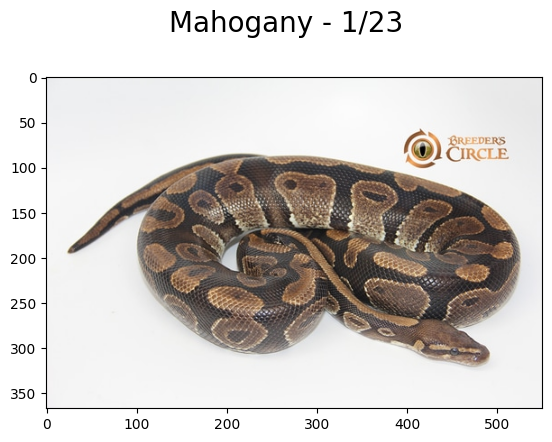

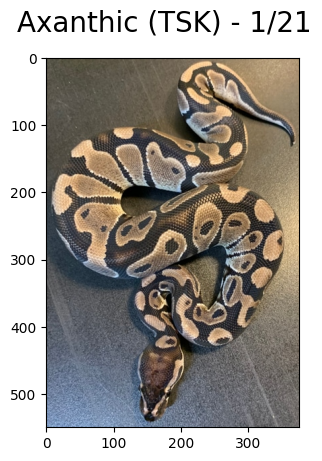

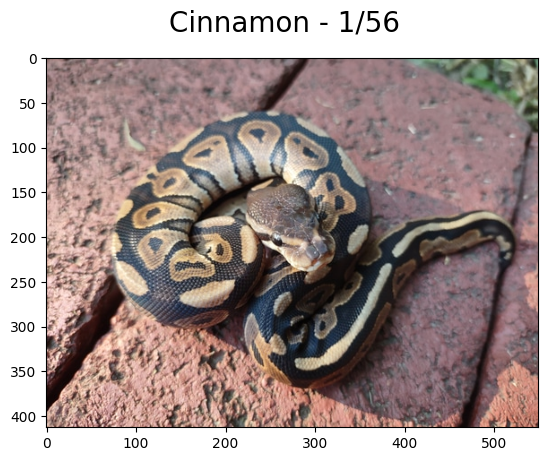

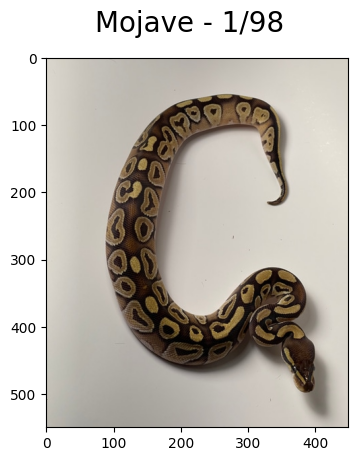

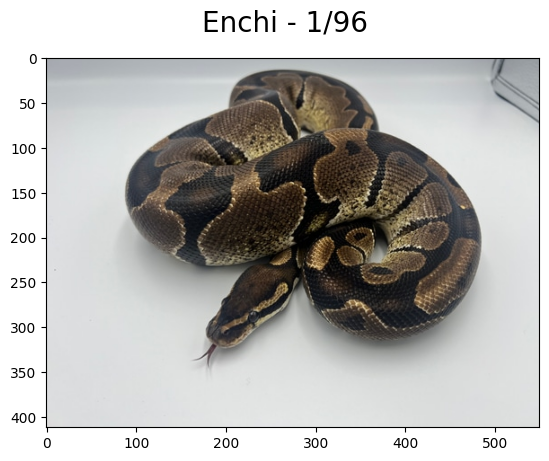

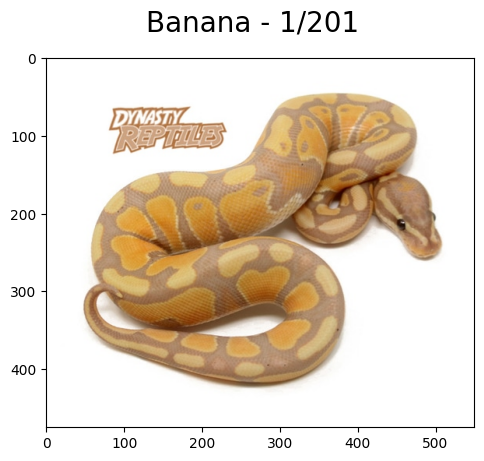

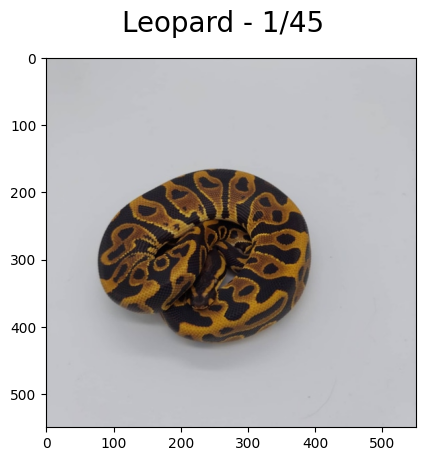

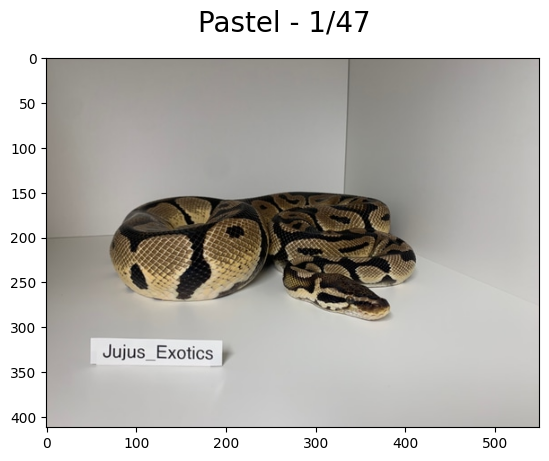

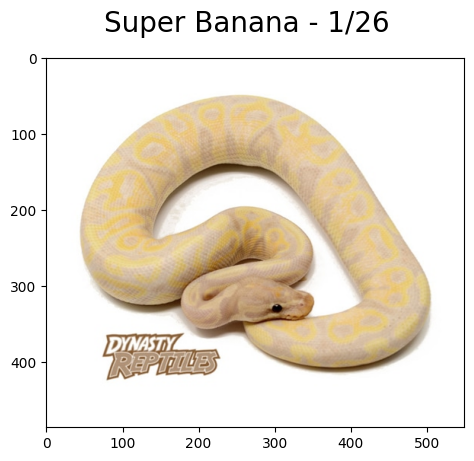

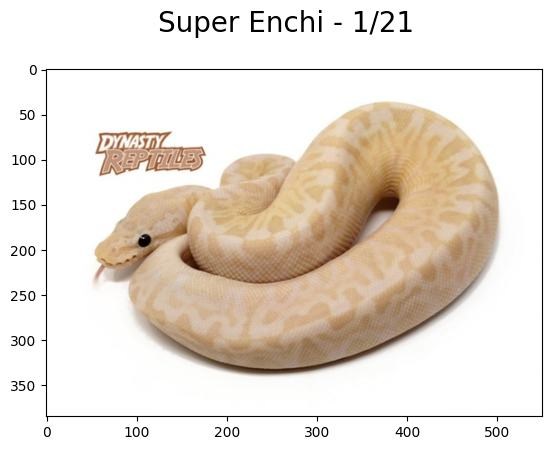

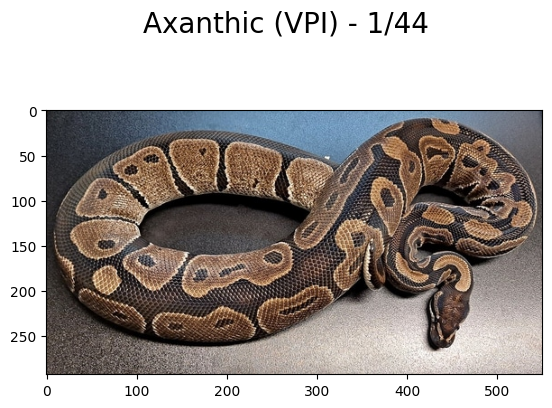

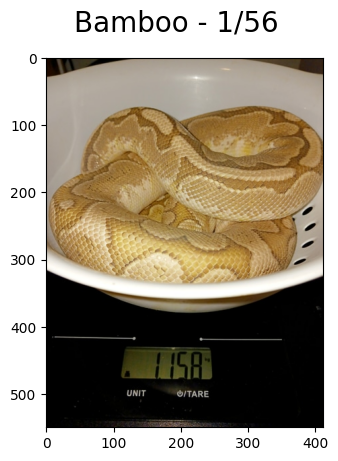

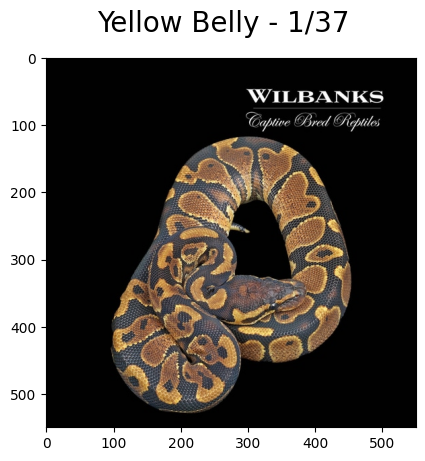

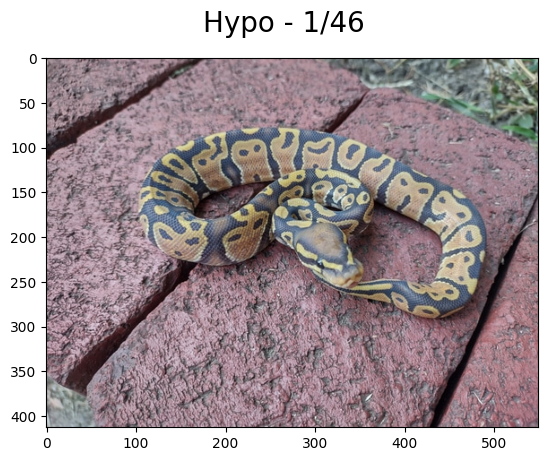

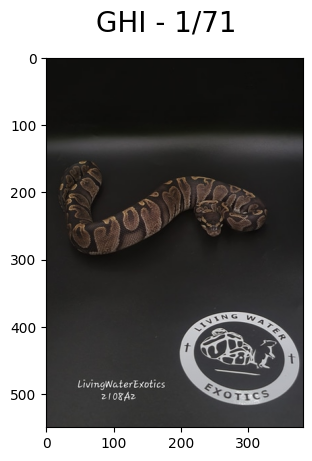

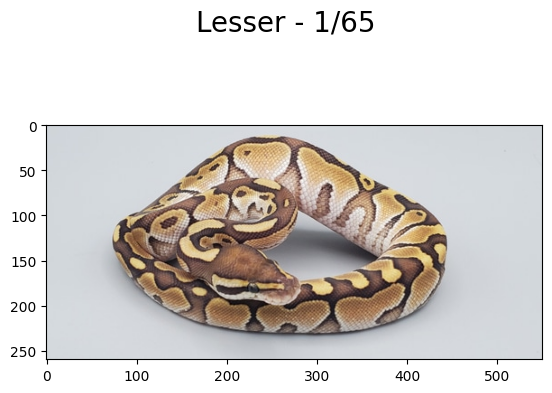

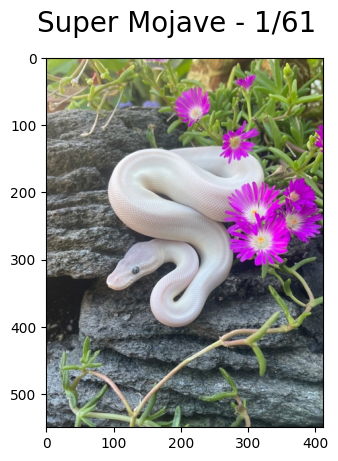

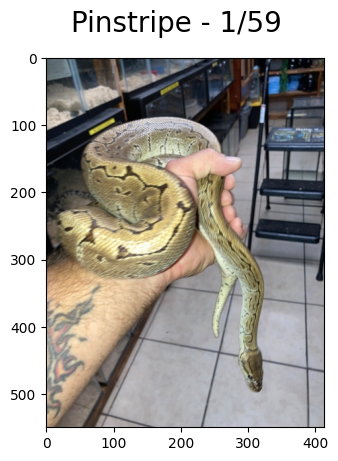

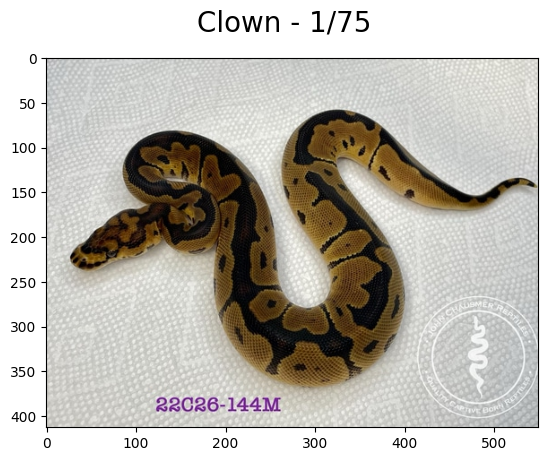

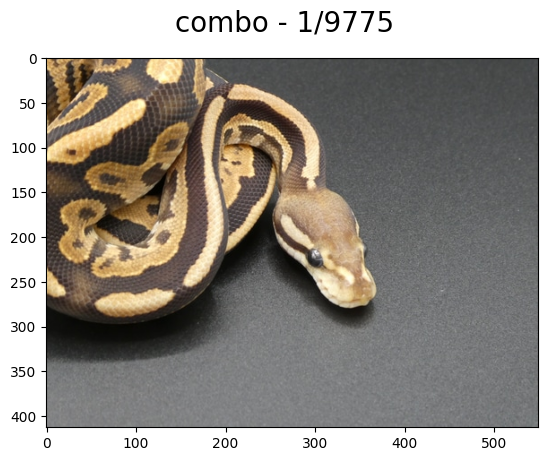

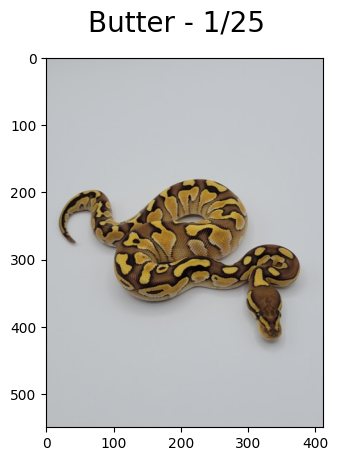

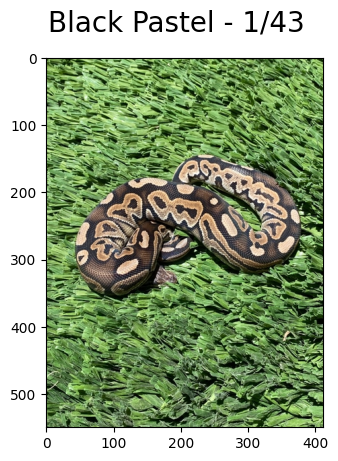

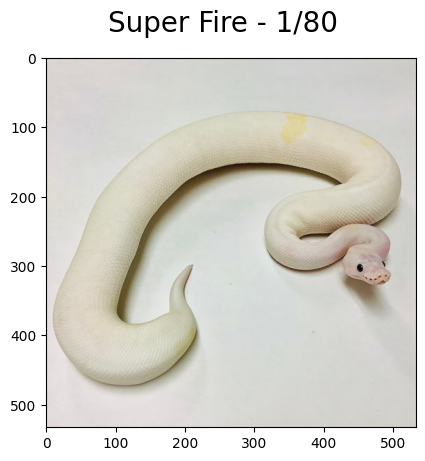

In [7]:
%matplotlib inline
total = 0
json_paths_list = []
for morph, morph_dict in morph_img_folder_dict.items():
    img_folder_list = morph_dict["img_folders"]
    image_paths = [[i+k for k in os.listdir(i) if k.endswith(".png")][0] for i in img_folder_list]
    json_paths = [[i+k for k in os.listdir(i) if k.endswith(".json")][0] for i in img_folder_list]
    json_paths_list.extend(json_paths)
    fig = plt.figure()
    image = Image.open(image_paths[0])
    plt.imshow(image)
    plt.suptitle(f"{morph} - 1/{morph_dict['num_imgs']}", fontsize=20)
    total += morph_dict["num_imgs"]
print(f"total imgs in dict: {total} - {len(morph_img_folder_dict)} morphs")

In [9]:
morph_details_dict = {}
all_image_details_dict = {}
for path in tqdm(json_paths_list):
    image_details_dict = {}
    cur_morph = path.split("/")[-3]
    if not morph_details_dict.get(cur_morph):
        morph_details_dict[cur_morph] = {}
    with open(path, "r") as f:
        image_details_dict = json.load(f)
        del image_details_dict["raw_details"]
    early_path = "/".join(path.split("/")[:-1])
    image_path = [f"{early_path}/{i}" for i in os.listdir(early_path) if not i.endswith(".json")][0]
    try:
        image = Image.open(image_path)
        image_details_dict["width"] = image.width
        image_details_dict["height"] = image.height
    except Exception as e:
        image_details_dict = {}
    if image_details_dict:
        morph_details_dict[cur_morph][image_path] = image_details_dict
        all_image_details_dict[image_path] = image_details_dict

  0%|          | 0/11719 [00:00<?, ?it/s]

In [10]:
metadata_df = pd.DataFrame.from_dict(all_image_details_dict, orient="index")
metadata_df = metadata_df.reset_index()
metadata_df = metadata_df.rename(columns={"index":"image_path"})

In [11]:
metadata_df.head()

image_path     sex  traits weight  \
0  /home/jordan/github/datasets/ball_pythons/Fire...  female  [Fire]   200g   
1  /home/jordan/github/datasets/ball_pythons/Fire...    male  [Fire]   760g   
2  /home/jordan/github/datasets/ball_pythons/Fire...  female  [Fire]  1900g   
3  /home/jordan/github/datasets/ball_pythons/Fire...  female  [Fire]  1644g   
4  /home/jordan/github/datasets/ball_pythons/Fire...  female  [Fire]    NaN   

       price  width  height         dob proven_breeder  
0  US$125.00    550     540         NaN            NaN  
1  US$100.00    412     550       2019             NaN  
2  US$500.00    412     550  July 2019             Yes  
3  US$375.00    440     550       2016             Yes  
4   US$85.00    550     413       2021             NaN

In [12]:
print(f"width - min: {metadata_df.width.min()} - median: {metadata_df.width.median()} - max: {metadata_df.width.max()}")
print(f"height - min: {metadata_df.height.min()} - median: {metadata_df.height.median()} - max: {metadata_df.height.max()}")

width - min: 155 - median: 550.0 - max: 550
height - min: 158 - median: 454.0 - max: 550


In [13]:
def square_crop(tensor):
        longer_side = min(tensor.size)
        horizontal_padding = (longer_side - tensor.size[0]) / 2
        vertical_padding = (longer_side - tensor.size[1]) / 2
        cropped_tensor = tensor.crop((-horizontal_padding,
                    -vertical_padding,
                    tensor.size[0] + horizontal_padding,
                    tensor.size[1] + vertical_padding
                ))
        return cropped_tensor

In [14]:
def get_split(array_to_split, split):
    np.random.seed(0)
    np.random.shuffle(array_to_split)
    np.random.seed()
    if split == 'train':
        array_to_split = array_to_split[:int(len(array_to_split)*0.7)]
    elif split == 'val':
        array_to_split = array_to_split[int(len(array_to_split)*0.7):int(len(array_to_split)*0.85)]
    elif split == 'test':
        array_to_split = array_to_split[int(len(array_to_split)*0.85):]
    return array_to_split

In [15]:
def count_number_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
class BallPythonDataset(Dataset):
    ##### Initialize the class #####
    def __init__(self, dataset_df, split = 'train'):
        ## Split parameter is used to specify which process the data is used for,
        ## and it can be 'train', 'val', and 'test
        
        labeled_df = dataset_df[['image_path', 'traits']]
        
        ## This is the name of all possible labels in this dataset.
        ## The corresponding label of each sample is an array of 14 elements in which the elements are ordered
        ## in the same way as "self.set_of_finding_labels" and the value of each element represents the 
        ## presence of that condition in the sample. For example, if "cardiomegaly" and "pneumonia" are the two 
        ## conditions presence a given sample, then the corresponding label of that sample is represented 
        ## by an array  - [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
        self.set_of_finding_labels = ['Atelectasis', 'Cardiomegaly','Effusion',  'Infiltration', 'Mass',\
                                      'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', \
                                      'Emphysema', 'Fibrosis','Pleural_Thickening', 'Hernia' ]
        
        ## Read labels from the label file
        examples_to_use['Finding Labels'] = examples_to_use['Finding Labels'].str.split(pat = '|')
        examples_to_use['Finding Labels'] = examples_to_use['Finding Labels'].apply(list).\
                                            to_frame(name='Finding Labels')
        for finding_label in self.set_of_finding_labels:
            examples_to_use[finding_label] = examples_to_use.apply(\
                                            lambda x: int(finding_label in x['Finding Labels']), axis=1)
        
        ## Get the list of all patient ids present in the dataset and split into
        ## training, validation and testing by patient id, but not by list of examples
        patient_ids = pd.unique(examples_to_use['Patient ID'])
        patient_ids = pd.DataFrame(get_split(patient_ids, split), columns = ['Patient ID'])
        
        ## Filter the examples to only use the ones that have the chosen patient ids
        examples_to_use = pd.merge(patient_ids,examples_to_use)        
        
        examples_to_use = examples_to_use[['Image Index'] + self.set_of_finding_labels]
        self.image_list = examples_to_use['Image Index'].values
        self.targets = examples_to_use[self.set_of_finding_labels].values
        
        ## Define data augmentation transformations for the input images. In this exercise, we use the following
        ## transformations: square center cropping, resizing to 224x224 (to be similar as ImageNet dataset), 
        ## converting to tensor, normalizing per channel (i.e., R, G, and B) 
        ## with the average and standard deviation of images in the ImageNet dataset        
        self.set_of_transforms = transforms.Compose(
        [square_crop(),
         transforms.Resize(224),
         transforms.ToTensor(), 
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
        
    ##### Retrieve a sample with the corresponding index #####
    ## This function retrieve a sample from the dataset at the specified index 
    ## and returns an image and the corresponding label stored in Pytorch tensors     
    def __getitem__(self, index):
        curr_pil_image = Image.open(self.path_image_folder + '/' + self.image_list[index]).convert('RGB')
        image_to_return = self.set_of_transforms(curr_pil_image)
                
        return image_to_return, torch.FloatTensor(self.targets[index])
    
    ##### Get the length of the dataset #####tm
    def __len__(self):
        return len(self.image_list)
    
    ##### Access the name of conditions in the labels #####
    def get_labels_name(self):
        return self.set_of_finding_labels

In [5]:
##### Request a GPU #####
## This function locates an available gpu for usage. In addition, this function reserves a specificed
## memory space exclusively for your account. The memory reservation prevents the decrement in computational
## speed when other users try to allocate memory on the same gpu in the shared systems, i.e., CADE machines. 
## Note: If you use your own system which has a GPU with less than 4GB of memory, remember to change the 
## specified mimimum memory.
def define_gpu_to_use(minimum_memory_mb = 8000):    
    thres_memory = 600 #
    gpu_to_use = None
    try: 
        os.environ['CUDA_VISIBLE_DEVICES']
        print('GPU already assigned before: ' + str(os.environ['CUDA_VISIBLE_DEVICES']))
        return
    except:
        pass
    
    torch.cuda.empty_cache()
    for i in range(16):
        free_memory = !nvidia-smi --query-gpu=memory.free -i $i --format=csv,nounits,noheader
        if free_memory[0] == 'No devices were found':
            break
        free_memory = int(free_memory[0])
        
        if free_memory>minimum_memory_mb-thres_memory:
            gpu_to_use = i
            break
            
    if gpu_to_use is None:
        print('Could not find any GPU available with the required free memory of ' + str(minimum_memory_mb) \
              + 'MB. Please use a different system for this assignment.')
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_to_use)
        print('Chosen GPU: ' + str(gpu_to_use) + f"with {free_memory}MB free")
        x = torch.rand((256,1024,minimum_memory_mb-thres_memory)).cuda()
        x = torch.rand((1,1)).cuda()        
        del x
        
## Request a gpu and reserve the memory space
define_gpu_to_use()

ValueError: invalid literal for int() with base 10: '/bin/bash: line 1: nvidia-smi: command not found'